In [2]:
# Importing all libraries you'll need throughout this analysis
from urllib.request import urlopen
import numpy as np
import pandas as pd
import mglearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
plt.style.use('ggplot')

In [3]:
# How i imported the data; It will be different if you download from Kaggle
# store the link in a variable
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
# iris = np.genfromtxt(url, delimiter=',', names=['sepal_length', 'sepal_width', 'petal_length','petal_width', 'class_flower'])

# Importing and cleaning

Finding where the data is changing the column names to a more standard form. I follow the tidy data principle. You read more about it here : https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html

In [4]:
# Data loading to the notebook
# Use read_csv from the pandas library i use the alias pd. instead of calling pandas all the time. 

iris = pd.read_csv('archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', index_col=False, names=['sepal_length', 'sepal_width', 'petal_length','petal_width', 'class'])

In [5]:
# Confirm if loading of the dataset was successful
# See the first 5 observations

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
# cleaning up class labels: These will be one-hot-encoded soon
# means that you'll change them into numbers since we'll be using matrices

# cleaning up the class/label names
iris['class'] = iris['class'].replace('Iris-setosa', 'setosa')
iris['class'] = iris['class'].replace('Iris-virginica', 'virginica')
iris['class'] = iris['class'].replace('Iris-versicolor', 'versicolor')

In [7]:
# Was it successful?
# seeing the last 5 entries of the dataset
iris.tail()

,sepal_length,sepal_width,petal_length,petal_width,class
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica


In [8]:
# concise summary about the dataset
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
class           150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


The columns are cool and consistent. This is important especially during visualization. You don't want to have columns labeled in an inconsistent way. You'll chuck your hair out if the columns are plenty. Now, let's convert the float64 type variables to float32 plus, confirm if there are missing values(*0's* or *NaNs* in our case).

In [9]:
# conversion step by step
# I've written the same code a couple of times, can you write a function to speed this up
# we are doing this conversion to speed up computation

iris['sepal_length'] = iris['sepal_length'].astype('float32')
iris['sepal_width'] = iris['sepal_width'].astype('float32')
iris['petal_length'] = iris['petal_length'].astype('float32')
iris['petal_width'] = iris['petal_width'].astype('float32')

In [10]:
# are there missing values
# I use this cool function called below. 

msg = 'I\'ve looked through your dataset. I found {} entries in your dataset with missing values.'
check_nans = sum(pd.isnull(iris).any())
print(msg.format(check_nans))

I've looked through your dataset. I found 0 entries in your dataset with missing values.


# Exploratory data analysis

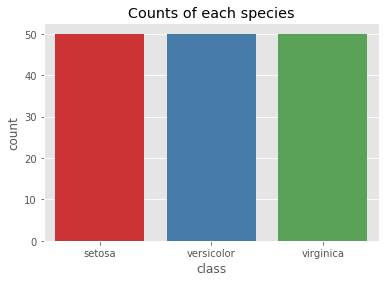

In [11]:
# Are the classes equal?
# Draw a countplot to confirm
# A guide about choosing colors in plots
# https://www.amazon.com/Designing-Data-Visualizations-Informational-Relationships/dp/1449312284

plt.title('Counts of each species')
sns.countplot(x = 'class', data = iris, palette='Set1')
plt.show()

# Alternatively, you can use plt.ion() to see plots

Wow! We have the same number of observations per class. This is great! Now when doing cross-validation it will be easy. Train-test-split with shuffling will suffice. One more plot. And that's how i figure out the cross-validation strategy.

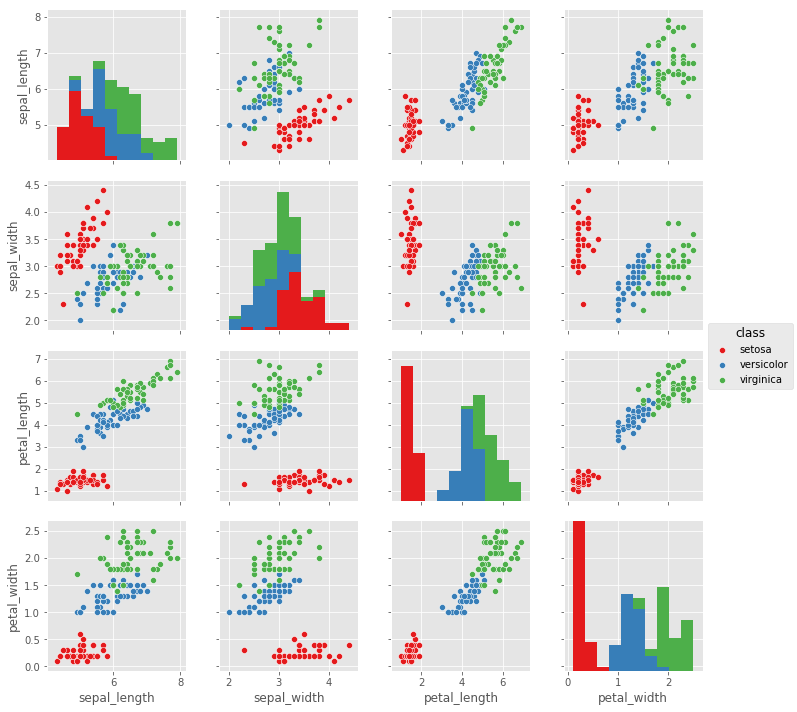

In [12]:
# check out the documentation of sns.pairplot like this in a cell ?sns.pairplot
# draws histograms, scatterplots
sns.pairplot(iris, hue = 'class', palette='Set1')
plt.show()

Making decision boundaries for this dataset will be easy for the class setosa since you can see from the pairwise plots of the different variables it's observations are all in a certain corner. However, virginica and versicolor will be more difficult to make a decision boundary. Unless we try using a standard scaler. This involves setting their observations to have a mean of 0 and a variance of 1. Remember the normal distribution.

In [13]:
# summary statistics
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843335,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


This is interesting the mean `sepal_width` and `petal_length` are very close that could bring some complications with your machine learning model/models. Therefore, standardizing the observations could be incredibly useful. In addition, you see the standard deviation (std) of the plants are different. Still you'll see the effect of the accuracy with and without standardization despite all the units being in centimeters.

The class column has words instead numbers this is not good. In machine learning, the primary input of models are matrices which is just rows and columns containing numbers. On the other hand, the target gives the model direction that is, given all the other predictors. How will you transform the data to get you close to the desired output? Classification of the plant species based on their measurements. So that if we have new observations our model will be able to classify the new plant with the iris genus. In short, our aim here is local generalization. If we had more plant measurements for different species we would be aiming for global generalization.

In [14]:
# Using the label encoder for the categorical variable
y = iris['class'].values # target

# Instantiate
le = LabelEncoder()

# fit and transform the specified column
y = le.fit_transform(y)

# confirm if we were successful
print(y)

# extracting the meaning of the classes, remembering this will come in handy
my_classes = le.classes_

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [15]:
# Converting the dataframe into a numpy arrays
# this is a necessary step to proceed with the analysis of the data set for the algorithm in the library to work 

X = iris.drop('class', axis = 1).values # storing predictors

# checking out if our conversion were successful
print (y); print('*' * 100) # the targets
print (X) ; print ('*' * 100) # the predictors
print (type(X)) # it's a ?

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
****************************************************************************************************
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.

In [16]:
# make train and test splits for cross-validation
# the rows are shuffled on default parameters of this function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123)

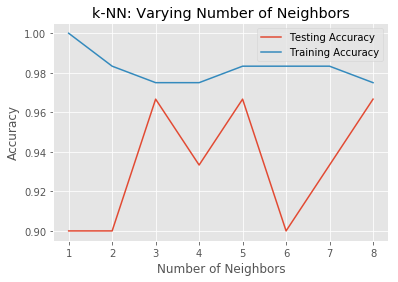

In [17]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9) # defining the range of values to test K
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setting up an knn classifier and storing results in a variable called knn
    knn = KNeighborsClassifier(n_neighbors = k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    # Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# the title of the graph
plt.title('k-NN: Varying Number of Neighbors') 

# plot the neighbours on the x axis values from 1-9 and their test accuracy
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy') 

# plot the neighbours on the x axis values from 1-9 and their train accuracy
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [18]:
# As a pipeline
# define your steps
steps = [('knn', KNeighborsClassifier())]

# call the pipeline function
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'knn__n_neighbors':[2,3,5]}

# Instantiate the GridSearchCV
cv = GridSearchCV(pipeline, param_grid=parameters, cv = 10)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the classes with the test set
y_pred = cv.predict(X_test)

# Compute and print metrics
# try computing the roc_auc
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Accuracy: 0.9666666666666667
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        13
          1       1.00      0.83      0.91         6
          2       0.92      1.00      0.96        11

avg / total       0.97      0.97      0.97        30

Tuned Model Parameters: {'knn__n_neighbors': 5}


<p align="center">
<img src="image/knn_intuition.png" width="550"> <br>
<figcaption>**Diagram of the decision boundaries made by KNN**</figcaption>
</p>

In [19]:
# Is it doing the right thing
# Let's give it something hard

try_it = np.array([[5.,3.4,1.5,0.2]]) # the 8th entry

# will your model give the right value 
try_prediction = cv.predict(try_it)

# an array we want to query our model with
print("Prediction: {}".format(try_it))

# Ask your model to find out what's the class of flower given the array
print("Predicted target name: {}".format(iris['class'][try_prediction]))

# making our work look pretty *wink*
print('*' * 100)

# subsetting the original dataframe with loc to see the 8th observation
print(iris.loc[8]); print ('*' * 100)

print ('Are you satisfied with this result?')

Prediction: [[5.  3.4 1.5 0.2]]
Predicted target name: 0    setosa
Name: class, dtype: object
****************************************************************************************************
sepal_length       4.4
sepal_width        2.9
petal_length       1.4
petal_width        0.2
class           setosa
Name: 8, dtype: object
****************************************************************************************************
Are you satisfied with this result?


Type your answer here: 

<p align="center">
<img src="image/code.jpg" width="550"> <br>
<figcaption>**Why i write comments in my code. Credit: Macharia**</figcaption>
</p>